In [1]:
import json
from pathlib import Path
from pprint import pprint, pformat
from utils.parse_frames import *
import nltk

In [2]:
with open(data_path, 'r') as data_file:    
    dials = json.load(data_file)

In [3]:
RED = '\x1b[31m'
BLUE = '\x1b[34m'
NC = '\x1b[0m'

def show_turn(dial_id, turn_id, filt='11111'):
    return '\n'.join(filter(None, [
        '' if filt[0] == '0' else '{}User   (raw):\n{}\n{}'.
            format(RED, data[dial_id]['turns'][turn_id*2]['text'], NC),
        '' if filt[2] == '0' else '{}System (raw):\n{}\n{}'.
            format(BLUE, data[dial_id]['turns'][turn_id*2+1]['text'], NC),
    ]))

In [4]:
def text_iterator(dials):
    for dial_id, dial in enumerate(dials):
        for turn_id, turn in enumerate(dial['turns']):
            yield turn['text']
            
def act_iterator(dials, authors=['user']):
    for dial_id, dial in enumerate(dials):
        for turn_id, turn in enumerate(dial['turns']):
            if turn['author'] in authors:
                for act in turn['labels']['acts']:
                    yield act

def slot_iterator(dials):
    """ Extract the tuples (action, slot, value).
    Use the labels in 'acts_without_refs' for each user turns.
    Ignore action with no slots because it's not evaluated.
    """
    for dial_id, dial in enumerate(dials):
        for turn_id, turn in enumerate(dial['turns']):
            if turn['author'] == 'user':
                for act in turn['labels']['acts_without_refs']:
                    for arg in act['args']:
                        yield act['name'], arg['key'], str(arg['val'])

## Examples of frame creation and switching
(El Asri *et al.*, FRAMES: A CORPUS FOR ADDING MEMORY TO GOAL-ORIENTED DIALOGUE SYSTEMS)
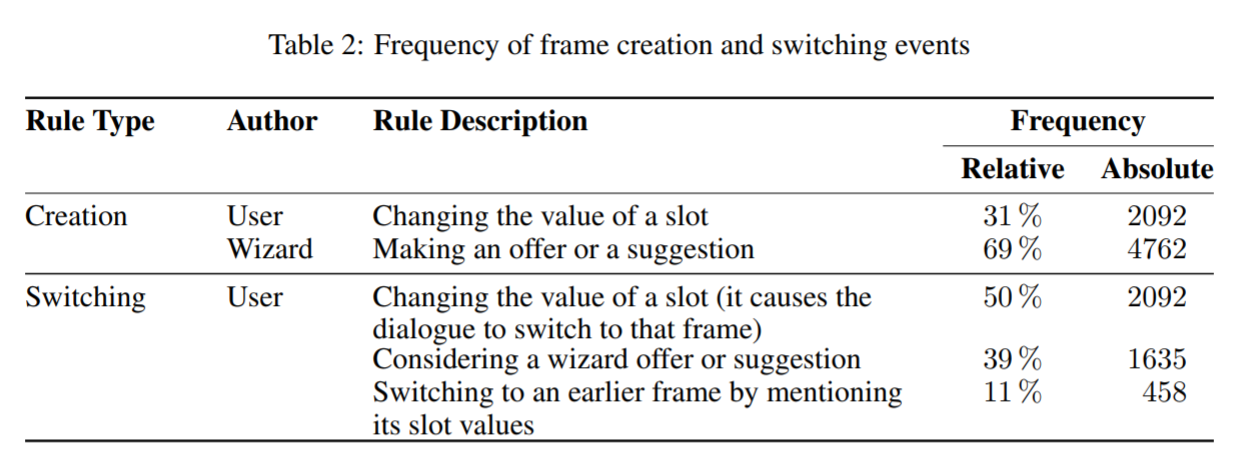

##### User create frame
dial_id = 0, turn_id = 2
- Yes , how about going to Neverland from Caprica on August 13 , 2016 for 5 adults . For this trip , my budget would be 1900 .

dial_id = 0, turn_id = 4
- I have no flexibility for dates ... but I can leave from Atlantis rather than Caprica . How about that ?

##### Wizard create frame
dial_id = 1, turn_id = 9
- I can book you a 3 day trip to Kobe leaving from Sapporo , Japan . Is this ok ?

dial_id = 1, turn_id = 11
- I can book you a trip from Birmingham to Kobe for 2747.8 USD .

##### User switch frame
dial_id = 0, turn_id = 2 (change a slot value, same as create frame)
- Yes , how about going to Neverland from Caprica on August 13 , 2016 for 5 adults . For this trip , my budget would be 1900 .

dial_id = 1, turn_id = 12 (mention a slot value)
- How many days would I be in Kobe ?

dial_id = 1, turn_id = 16 (consider a wizard offer)
- Ok , then I would like to purchase this package . What activities are included in this package ?

dial_id = 4, turn_id = 6 (mention a slot value)
- Ok , I would like to purchase the trip with the 4 - star hotel .

## Examples of other labels
##### ref_anaphora
dial_id = 1, turn_id = 10
- No , that's too far for me . I need a flight that leaves from Birmingham .

dial_id = 1, turn_id = 16
- Ok , then I would like to purchase this package . What activities are included in this package ?

##### negate
dial_id = 1, turn_id = 10
- No , that's too far for me . I need a flight that leaves from Birmingham .

##### strange parent_frame_id
dial_id = 1, turn_id = 10 (what should the dst_city be in frame 7?)
- No , that's too far for me . I need a flight that leaves from Birmingham .

##### request_compare
dial_id = 4, turn_id = 4
- Do these packages have different departure dates ? When would I be leaving for each of them ?

## Examples of request_compare

dial_id = 10, turn_id = 4
- Let's look at both

dial_id = 4, turn_id = 4
- Do these packages have different departure dates ? When would I be leaving for each of them ?

dial_id = 25, turn_id = 8
- I'd like to compare the Cairo and Punta Cana packages . What are the hotels , how many stars , free wifi , free breakfast ?

## Examples of referencing without slot values or anaphora (mostly refers to the last few suggestions)

##### request_compare (< 30)
dial_id = 72, turn id = 8
- amazing glad to know and opposed to Mexico City what does the price look like

dial_id = 89, turn id = 14
- which hotel is better ?

dial_id = 210, turn id = 10
- BOT: In Porto I have Delux , Breakwater and the Golden Keep Hotel all available for 4 day packages .
- USER: Can you show me some prices and ratings to compare ?

dial_id = 255, turn id = 4
- wwhich one offers better amenities ?

##### switch_frame (~260)

dial id = 3, turn id = 8
- BOT: Yes , I do . I have one for 8445.37 USD . Would you like to book this package ? The guest rating is 7.15 / 10 and ...
- USER: Is breakfast included ?

dial id = 33, turn id = 6
- BOT: Ok . I can upgrade your flights to business class for a total of 2715.60 USD . Would you like that ?
- USER: Yes perfect . How is the hotel ?

dial id = 35, turn id = 26
- BOT: Would you like me to explore your Fukuoka options leaving from Porto Alegre ?
- USER: Yes please .

dial id = 1191, turn id = 4
- BOT: Okay , our best deal in Santos is a 7 day trip at a 3.5 star hotel near a museum and a palace .
- USER: Reasonable . Any free wifi for the kids ?

## Statistics of special label: switch_frame and request_compare

In [5]:
n_acts = len(list(act_iterator(dials)))
n_switch_frame = len(list(filter(
    lambda a: a['name'] == 'switch_frame', act_iterator(dials))))
n_request_compare = len(list(filter(
    lambda a: a['name'] == 'request_compare', act_iterator(dials))))
print('# acts = {}'.format(n_acts))
print('# switch_frame = {}'.format(n_switch_frame))
print('# request_compare = {}'.format(n_request_compare))

# acts = 14172
# switch_frame = 2102
# request_compare = 214
